# 🌙 CL837 Sleep Data Analysis

Complete notebook for:
1. Connect to CL837 device via Bluetooth
2. UTC time synchronization
3. Download sleep data
4. Export to CSV
5. Visualize charts by night

**Requirements:** CL837 device powered on and nearby

In [1]:
# Imports
import asyncio
import time
import csv
from datetime import datetime, timezone, timedelta
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bleak import BleakClient, BleakScanner
import ast

# To run asyncio in Jupyter
import nest_asyncio
nest_asyncio.apply()

print("✅ Imports complete")

✅ Imports complete


## 📡 BLE Configuration

Chileaf protocol constants for Bluetooth Low Energy communication.

In [3]:
# Load from existing CSV (skip BLE download)
import csv
import ast

csv_file = "sleep_data_20251204_115757.csv"

all_records = []
with open(csv_file, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        all_records.append({
            'utc': int(row['utc_timestamp']),
            'count': int(row['interval_count']),
            'activity_indices': ast.literal_eval(row['activity_indices'])
        })

print(f"✅ Loaded {len(all_records)} records from {csv_file}")

✅ Loaded 51 records from sleep_data_20251204_115757.csv


In [2]:
# Chileaf Protocol Constants
CHILEAF_SERVICE_UUID = "aae28f00-71b5-42a1-8c3c-f9cf6ac969d0"
CHILEAF_TX_UUID = "aae28f01-71b5-42a1-8c3c-f9cf6ac969d0"  # Notifications
CHILEAF_RX_UUID = "aae28f02-71b5-42a1-8c3c-f9cf6ac969d0"  # Write

CHILEAF_HEADER = 0xFF
CMD_SET_UTC = 0x08
CMD_GET_SLEEP = 0x05

# Validation
MIN_VALID_TIMESTAMP = 1577836800  # 2020-01-01

# Storage
all_records = []
data_complete = False
utc_confirmed = False

def calculate_checksum(data):
    """Calculate Chileaf checksum: ((0 - sum) & 0xFF) ^ 0x3A"""
    checksum = sum(data) & 0xFF
    checksum = (0 - checksum) & 0xFF
    checksum = checksum ^ 0x3A
    return checksum

print("✅ BLE configuration ready")

✅ BLE configuration ready


## 🔗 Connect and Download Data

Run this cell to:
1. Scan for CL837 device
2. Connect
3. Sync UTC time
4. Download all sleep data

In [70]:
def notification_handler(sender, data):
    """Handle BLE notifications from device"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    if len(data) < 3 or data[0] != CHILEAF_HEADER:
        return
    
    command = data[2]
    
    # UTC sync confirmation
    if command == CMD_SET_UTC:
        utc_confirmed = True
    
    # Sleep data response
    elif command == CMD_GET_SLEEP and len(data) > 3:
        subcommand = data[3]
        last_packet_time = time.time()  # Track last packet received
        
        if subcommand == 0x03:  # Sleep data packet
            payload_end = data[1]
            idx = 4
            
            while idx < payload_end - 1:
                count = data[idx]
                idx += 1
                
                if idx + 4 > len(data):
                    break
                
                # Read UTC timestamp (4 bytes, big-endian)
                utc = (data[idx] << 24) | (data[idx+1] << 16) | (data[idx+2] << 8) | data[idx+3]
                idx += 4
                
                # Read activity indices
                activity_indices = []
                for i in range(count):
                    if idx < len(data) - 1:
                        activity_indices.append(data[idx])
                        idx += 1
                
                all_records.append({
                    'utc': utc,
                    'count': count,
                    'activity_indices': activity_indices
                })
        
        elif subcommand == 0xFF:  # End of data marker
            data_complete = True


async def download_sleep_data():
    """Connect to device and download sleep data"""
    global all_records, data_complete, utc_confirmed, last_packet_time
    
    # Reset
    all_records = []
    data_complete = False
    utc_confirmed = False
    last_packet_time = 0
    
    print("🔍 Scanning for CL837 devices...")
    devices = await BleakScanner.discover(timeout=8.0)
    cl837_devices = [d for d in devices if d.name and ("CL837" in d.name or "CL831" in d.name)]
    
    if not cl837_devices:
        print("❌ No CL837 devices found")
        return False
    
    device = cl837_devices[0]
    print(f"📱 Found: {device.name}")
    
    async with BleakClient(device, timeout=15.0) as client:
        print("✅ Connected")
        
        # Find characteristics
        tx_char = None
        rx_char = None
        for service in client.services:
            if service.uuid.lower() == CHILEAF_SERVICE_UUID.lower():
                for char in service.characteristics:
                    if char.uuid.lower() == CHILEAF_TX_UUID.lower():
                        tx_char = char
                    elif char.uuid.lower() == CHILEAF_RX_UUID.lower():
                        rx_char = char
        
        if not tx_char or not rx_char:
            print("❌ Chileaf characteristics not found")
            return False
        
        # Start notifications
        await client.start_notify(tx_char, notification_handler)
        await asyncio.sleep(0.3)
        
        # Sync UTC time
        print("\n⏰ Syncing UTC time...")
        utc_timestamp = int(time.time())
        utc_bytes = [
            (utc_timestamp >> 24) & 0xFF,
            (utc_timestamp >> 16) & 0xFF,
            (utc_timestamp >> 8) & 0xFF,
            utc_timestamp & 0xFF
        ]
        frame = [CHILEAF_HEADER, 0x08, CMD_SET_UTC] + utc_bytes
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        await asyncio.sleep(1.0)
        print(f"   UTC: {datetime.fromtimestamp(utc_timestamp, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')}")
        print("✅ UTC sync sent")
        
        # Request sleep data
        print("\n💤 Requesting sleep data...")
        frame = [CHILEAF_HEADER, 0x05, CMD_GET_SLEEP, 0x02]
        frame.append(calculate_checksum(frame))
        await client.write_gatt_char(rx_char, bytes(frame))
        
        # Wait for data - improved logic
        print("⏳ Waiting for data...")
        last_packet_time = time.time()
        timeout = 45  # Increased timeout
        idle_timeout = 3  # Stop if no packets for 3 seconds
        start = time.time()
        prev_count = 0
        
        while (time.time() - start) < timeout:
            await asyncio.sleep(0.3)
            
            # Check if we got end marker
            if data_complete:
                print("   📦 End marker received")
                break
            
            # Check for idle timeout (no new packets)
            if last_packet_time > 0 and (time.time() - last_packet_time) > idle_timeout:
                if len(all_records) > prev_count:
                    prev_count = len(all_records)
                    continue  # Still receiving, reset
                else:
                    print(f"   ⏱️ No new data for {idle_timeout}s, finishing...")
                    break
            
            # Progress indicator
            if len(all_records) > prev_count:
                print(f"   📥 {len(all_records)} records...")
                prev_count = len(all_records)
        
        await client.stop_notify(tx_char)
    
    print(f"\n✅ Downloaded {len(all_records)} raw records")
    return True

# Run the download
asyncio.run(download_sleep_data())

🔍 Scanning for CL837 devices...
📱 Found: CL837-0759364
📱 Found: CL837-0759364
✅ Connected
✅ Connected

⏰ Syncing UTC time...

⏰ Syncing UTC time...
   UTC: 2025-12-04 10:57:56
✅ UTC sync sent

💤 Requesting sleep data...
⏳ Waiting for data...
   UTC: 2025-12-04 10:57:56
✅ UTC sync sent

💤 Requesting sleep data...
⏳ Waiting for data...
   📦 End marker received

✅ Downloaded 94 raw records
   📦 End marker received

✅ Downloaded 94 raw records


True

## 🔍 Validation and Sleep Stage Analysis

Filter valid records and classify sleep stages using the Chileaf SDK algorithm:
- **Deep Sleep**: 3+ consecutive zeros in activity index
- **Light Sleep**: activity 1-20 or < 3 consecutive zeros
- **Awake**: activity > 20

In [4]:
def analyze_sleep_stages(activity_indices):
    """
    Analyze sleep stages using Chileaf SDK algorithm.
    Each interval = 5 minutes
    """
    deep, light, awake = 0, 0, 0
    consecutive_zeros = 0
    
    for action in activity_indices:
        if action == 0:
            consecutive_zeros += 1
        else:
            # Process accumulated zeros
            if consecutive_zeros >= 3:
                deep += consecutive_zeros
            elif consecutive_zeros > 0:
                light += consecutive_zeros
            consecutive_zeros = 0
            
            # Process current value
            if action > 20:
                awake += 1
            else:  # 1-20
                light += 1
    
    # Process remaining zeros
    if consecutive_zeros >= 3:
        deep += consecutive_zeros
    elif consecutive_zeros > 0:
        light += consecutive_zeros
    
    return deep * 5, light * 5, awake * 5  # Convert to minutes


# Validate and process records
current_time = int(time.time())
valid_records = []

for rec in all_records:
    utc = rec['utc']
    count = rec['count']
    
    # Validate timestamp
    if utc >= MIN_VALID_TIMESTAMP and utc <= current_time and count > 0:
        deep, light, awake = analyze_sleep_stages(rec['activity_indices'])
        
        valid_records.append({
            'utc': utc,
            'datetime': datetime.fromtimestamp(utc, tz=timezone.utc),
            'duration_min': count * 5,
            'deep_min': deep,
            'light_min': light,
            'awake_min': awake,
            'activity_indices': rec['activity_indices']
        })

# Sort by timestamp
valid_records.sort(key=lambda x: x['utc'])

print(f"📊 Total raw records: {len(all_records)}")
print(f"✅ Valid records: {len(valid_records)}")
print(f"❌ Filtered records: {len(all_records) - len(valid_records)}")

if valid_records:
    print(f"\n📅 Range: {valid_records[0]['datetime'].strftime('%Y-%m-%d')} → {valid_records[-1]['datetime'].strftime('%Y-%m-%d')}")

📊 Total raw records: 51
✅ Valid records: 51
❌ Filtered records: 0

📅 Range: 2025-11-07 → 2025-12-04


In [72]:
# Debug: Show last 20 raw records with timestamps
print(f"Total raw records: {len(all_records)}")
print("\nLast 20 raw records:")
for i, rec in enumerate(all_records[-20:], len(all_records)-19):
    utc = rec['utc']
    try:
        dt = datetime.fromtimestamp(utc, tz=timezone.utc).strftime('%Y-%m-%d %H:%M')
    except:
        dt = "INVALID"
    valid = "✅" if utc >= MIN_VALID_TIMESTAMP else "❌"
    print(f"  {i}: UTC={utc} → {dt} {valid} count={rec['count']}")

Total raw records: 94

Last 20 raw records:
  75: UTC=1764739186 → 2025-12-03 05:19 ✅ count=12
  76: UTC=1764742786 → 2025-12-03 06:19 ✅ count=1
  77: UTC=1764740369 → 2025-12-03 05:39 ✅ count=5
  78: UTC=1764741501 → 2025-12-03 05:58 ✅ count=12
  79: UTC=1764789901 → 2025-12-03 19:25 ✅ count=12
  80: UTC=1764793501 → 2025-12-03 20:25 ✅ count=12
  81: UTC=1764797101 → 2025-12-03 21:25 ✅ count=12
  82: UTC=1764800701 → 2025-12-03 22:25 ✅ count=12
  83: UTC=1764804301 → 2025-12-03 23:25 ✅ count=12
  84: UTC=1764807901 → 2025-12-04 00:25 ✅ count=12
  85: UTC=1764811501 → 2025-12-04 01:25 ✅ count=12
  86: UTC=1764815101 → 2025-12-04 02:25 ✅ count=12
  87: UTC=1764818701 → 2025-12-04 03:25 ✅ count=12
  88: UTC=1764822301 → 2025-12-04 04:25 ✅ count=12
  89: UTC=1764825901 → 2025-12-04 05:25 ✅ count=12
  90: UTC=1764829501 → 2025-12-04 06:25 ✅ count=12
  91: UTC=1764833101 → 2025-12-04 07:25 ✅ count=12
  92: UTC=1764836701 → 2025-12-04 08:25 ✅ count=2
  93: UTC=1764842415 → 2025-12-04 10:00 ✅

## 💾 Export CSV

Save validated data to a timestamped CSV file.

In [73]:
# Export to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"sleep_data_{timestamp}.csv"

if valid_records:
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=[
            'record_number', 'utc_timestamp', 'datetime_utc', 'duration_minutes',
            'interval_count', 'deep_sleep_min', 'light_sleep_min', 'awake_min', 'activity_indices'
        ])
        writer.writeheader()
        
        for i, rec in enumerate(valid_records, 1):
            writer.writerow({
                'record_number': i,
                'utc_timestamp': rec['utc'],
                'datetime_utc': rec['datetime'].strftime('%Y-%m-%d %H:%M:%S'),
                'duration_minutes': rec['duration_min'],
                'interval_count': rec['duration_min'] // 5,
                'deep_sleep_min': rec['deep_min'],
                'light_sleep_min': rec['light_min'],
                'awake_min': rec['awake_min'],
                'activity_indices': str(rec['activity_indices'])
            })
    
    print(f"✅ Exported to: {csv_filename}")
else:
    print("⚠️ No valid records to export")

✅ Exported to: sleep_data_20251204_115757.csv


## 🌙 Group by Night

Group records into sleep sessions (nights):
- Gap > 3 hours = new session
- Calculate totals for each night

In [5]:
# Local timezone offset (Italy = UTC+1, or UTC+2 during DST)
LOCAL_TZ_OFFSET = 1  # hours from UTC

# ========== PLAUSIBLE SLEEP WINDOWS ==========
# Only data within these windows is considered valid sleep
# Night: 20:00 - 10:00 (next day)
# Nap:   12:00 - 16:00 (post-prandial)

NIGHT_WINDOW_START = 20   # 20:00
NIGHT_WINDOW_END = 10     # 10:00 next day
NAP_WINDOW_START = 12     # 12:00
NAP_WINDOW_END = 16       # 16:00

# Session classification thresholds
MIN_NIGHT_DURATION = 180  # 3 hours minimum for "real" night
NIGHT_START_HOUR = 20     # 20:00 - night starts
NIGHT_END_HOUR = 10       # 10:00 - night ends
MIN_DEEP_PERCENT = 15     # minimum deep sleep % for quality

def format_duration(minutes):
    """Format duration in hours and minutes"""
    hours = minutes // 60
    mins = minutes % 60
    if hours > 0:
        return f"{hours}h {mins}m"
    return f"{mins}m"


def get_night_label(dt):
    """Generate label for the night (using local time)"""
    local_dt = dt + timedelta(hours=LOCAL_TZ_OFFSET)
    night_date = (local_dt - timedelta(hours=18)).date() if local_dt.hour < 18 else local_dt.date()
    next_day = night_date + timedelta(days=1)
    return f"{night_date.strftime('%d')}→{next_day.strftime('%d %b')}"


def to_local(dt):
    """Convert UTC datetime to local time"""
    return dt + timedelta(hours=LOCAL_TZ_OFFSET)


def is_in_plausible_sleep_window(dt):
    """
    Check if a datetime falls within plausible sleep windows:
    - Night: 20:00 - 10:00 (next day)
    - Nap:   12:00 - 16:00
    Returns: (is_valid, window_type)
    """
    local_dt = to_local(dt)
    hour = local_dt.hour
    
    # Night window: 20:00-23:59 OR 00:00-10:00
    if hour >= NIGHT_WINDOW_START or hour < NIGHT_WINDOW_END:
        return True, "night"
    
    # Nap window: 12:00-16:00
    if NAP_WINDOW_START <= hour < NAP_WINDOW_END:
        return True, "nap"
    
    return False, None


def classify_session(bedtime, wake_time, total_min, deep_min):
    """
    Classify sleep session type:
    - 🌙 NIGHT: real overnight sleep (long, nighttime hours, good deep%)
    - 😴 NAP: short daytime sleep
    - 🛋️ REST: possible false positive (sitting/resting, not real sleep)
    """
    local_bed = to_local(bedtime)
    local_wake = to_local(wake_time)
    bed_hour = local_bed.hour
    wake_hour = local_wake.hour
    
    # Check if in nighttime window
    is_nighttime = (bed_hour >= NIGHT_START_HOUR or bed_hour < 4) or (wake_hour <= NIGHT_END_HOUR or wake_hour >= 23)
    
    # Calculate deep sleep percentage
    deep_pct = (deep_min / total_min * 100) if total_min > 0 else 0
    
    # Classification logic
    if total_min >= MIN_NIGHT_DURATION and is_nighttime:
        return "🌙 NIGHT", "Primary sleep session"
    elif total_min >= 60 and total_min < MIN_NIGHT_DURATION:
        if 11 <= bed_hour <= 17:
            return "😴 NAP", "Daytime nap"
        else:
            return "🌙 NIGHT?", "Short night (interrupted?)"
    elif total_min >= 30 and total_min < 60:
        return "😴 NAP", "Short rest"
    else:
        if deep_pct < 10:
            return "🛋️ REST", "Possibly not real sleep"
        return "😴 NAP", "Brief sleep"


# ========== FILTER RECORDS BY PLAUSIBLE SLEEP WINDOWS ==========
print("🔍 Filtering records by plausible sleep windows...")
print(f"   🌙 Night window: {NIGHT_WINDOW_START}:00 → {NIGHT_WINDOW_END}:00")
print(f"   😴 Nap window:   {NAP_WINDOW_START}:00 → {NAP_WINDOW_END}:00\n")

filtered_records = []
rejected_records = []

for rec in valid_records:
    rec_time = rec['datetime']
    is_valid, window_type = is_in_plausible_sleep_window(rec_time)
    
    if is_valid:
        rec['window_type'] = window_type
        filtered_records.append(rec)
    else:
        rejected_records.append(rec)

print(f"📊 Original records: {len(valid_records)}")
print(f"✅ Plausible sleep:  {len(filtered_records)}")
print(f"❌ Rejected:         {len(rejected_records)}")

if rejected_records:
    print(f"\n⚠️ Rejected records (outside sleep windows):")
    for rec in rejected_records[:10]:  # Show first 10
        local_time = to_local(rec['datetime'])
        print(f"   {local_time.strftime('%Y-%m-%d %H:%M')} - {rec['duration_min']}min")
    if len(rejected_records) > 10:
        print(f"   ... and {len(rejected_records) - 10} more")


# Group into sessions (gap > 3 hours = new session)
# Using filtered_records now!
sessions = []
current_session = []

for rec in filtered_records:  # <-- CHANGED: use filtered_records
    if not current_session:
        current_session.append(rec)
    else:
        last_utc = current_session[-1]['utc']
        last_duration = current_session[-1]['duration_min'] * 60  # in seconds
        gap = rec['utc'] - (last_utc + last_duration)
        
        if gap > 3 * 3600:  # > 3 hours
            sessions.append(current_session)
            current_session = [rec]
        else:
            current_session.append(rec)

if current_session:
    sessions.append(current_session)

# Calculate stats for each session
nights_data = []

for session in sessions:
    deep = sum(r['deep_min'] for r in session)
    light = sum(r['light_min'] for r in session)
    awake = sum(r['awake_min'] for r in session)
    total = deep + light + awake
    
    if total == 0:
        continue
    
    bedtime = session[0]['datetime']
    wake_time = session[-1]['datetime'] + timedelta(minutes=session[-1]['duration_min'])
    efficiency = ((deep + light) / total * 100) if total > 0 else 0
    
    # Classify the session
    session_type, session_note = classify_session(bedtime, wake_time, total, deep)
    
    nights_data.append({
        'label': get_night_label(bedtime),
        'bedtime': bedtime,
        'wake_time': wake_time,
        'deep': deep,
        'light': light,
        'awake': awake,
        'total': total,
        'efficiency': efficiency,
        'records': len(session),
        'type': session_type,
        'note': session_note
    })

print(f"\n{'='*100}")
print(f"🌙 Found {len(nights_data)} VALID sleep sessions (times in local: UTC+{LOCAL_TZ_OFFSET})")
print("="*100)
print(f"{'Type':<12} {'Night':<15} {'Bedtime':<8} {'Wake':<8} {'Total':<10} {'Deep':<10} {'Light':<10} {'Note':<20}")
print("-"*100)

for night in nights_data:
    local_bed = to_local(night['bedtime'])
    local_wake = to_local(night['wake_time'])
    deep_pct = night['deep'] / night['total'] * 100 if night['total'] > 0 else 0
    print(f"{night['type']:<12} {night['label']:<15} {local_bed.strftime('%H:%M'):<8} {local_wake.strftime('%H:%M'):<8} "
          f"{format_duration(night['total']):<10} {format_duration(night['deep']):<10} "
          f"{format_duration(night['light']):<10} {night['note']:<20}")

print("="*100)

# Summary
real_nights = [n for n in nights_data if "NIGHT" in n['type'] and "?" not in n['type']]
naps = [n for n in nights_data if "NAP" in n['type']]
rest = [n for n in nights_data if "REST" in n['type']]

print(f"\n📊 Summary: {len(real_nights)} real nights, {len(naps)} naps, {len(rest)} rest periods")

🔍 Filtering records by plausible sleep windows...
   🌙 Night window: 20:00 → 10:00
   😴 Nap window:   12:00 → 16:00

📊 Original records: 51
✅ Plausible sleep:  44
❌ Rejected:         7

⚠️ Rejected records (outside sleep windows):
   2025-11-08 11:41 - 45min
   2025-11-08 18:19 - 60min
   2025-11-08 19:19 - 60min
   2025-11-09 16:56 - 50min
   2025-11-09 18:26 - 40min
   2025-12-04 10:33 - 15min
   2025-12-04 11:00 - 20min

🌙 Found 6 VALID sleep sessions (times in local: UTC+1)
Type         Night           Bedtime  Wake     Total      Deep       Light      Note                
----------------------------------------------------------------------------------------------------
🌙 NIGHT      07→08 Nov       21:25    00:40    3h 15m     2h 40m     35m        Primary sleep session
🛋️ REST      07→08 Nov       13:44    13:59    15m        0m         15m        Possibly not real sleep
🌙 NIGHT      08→09 Nov       20:19    05:29    9h 30m     5h 55m     3h 35m     Primary sleep session
😴 NAP  

## 📊 Donut Charts by Night

Visualize sleep stage distribution for each night with:
- Deep Sleep (dark blue)
- Light Sleep (light blue)
- Awake (orange)
- Total duration in center
- Bedtime and wake time

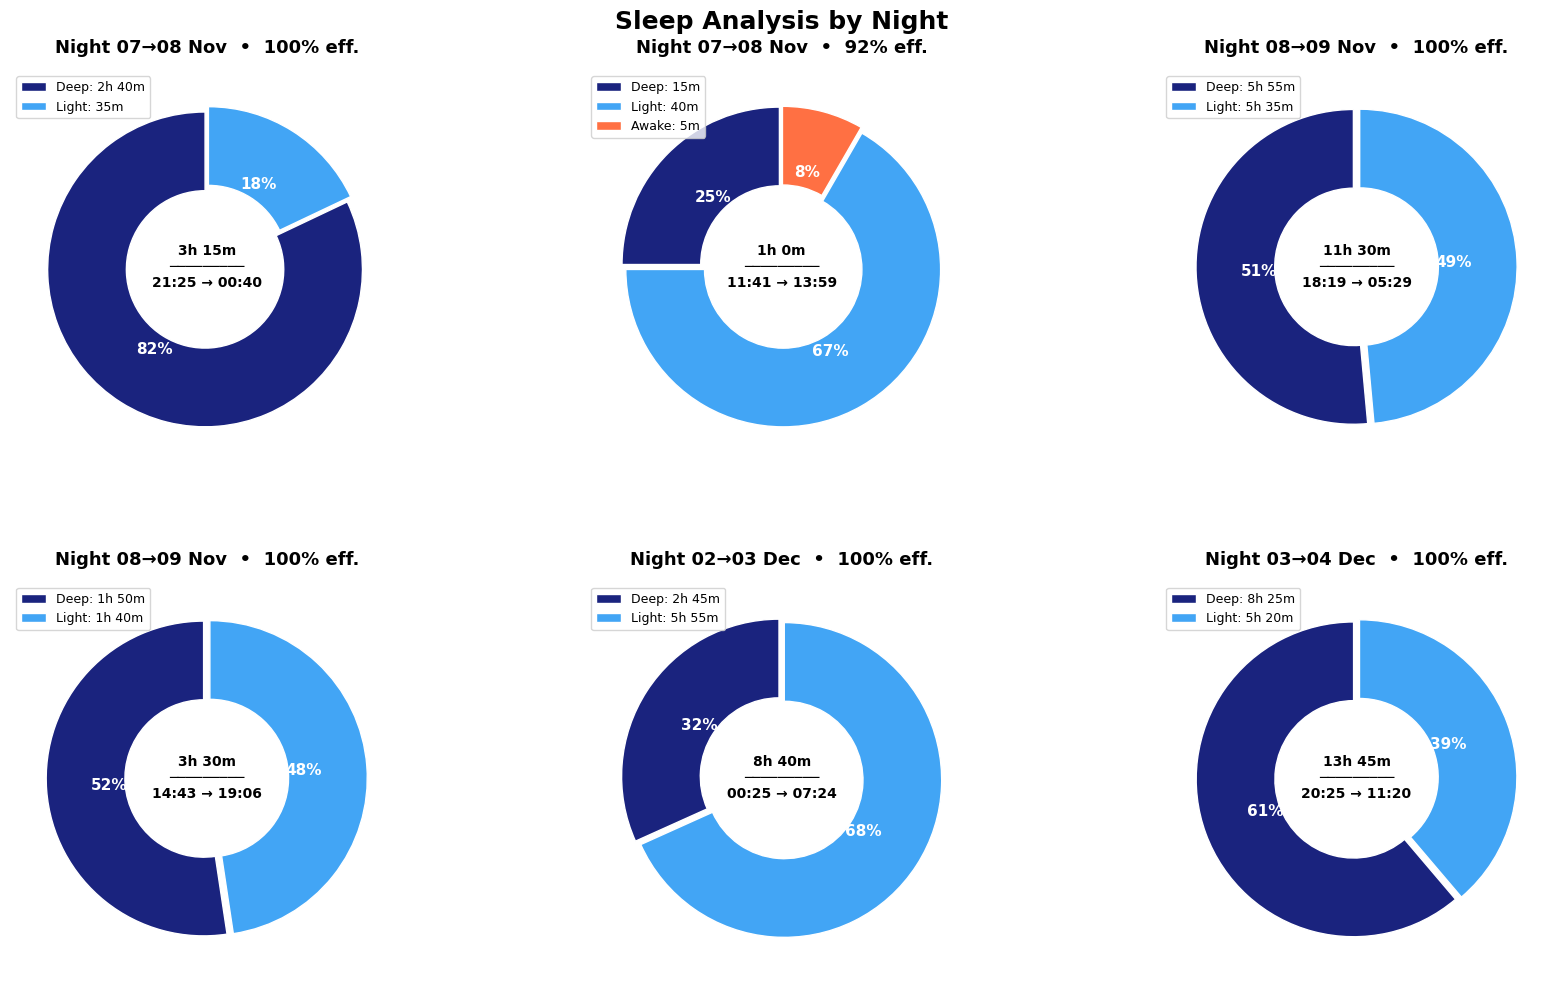


✅ Saved: night_donuts.png


In [75]:
# Clear any previous figures
plt.close('all')

if not nights_data:
    print("⚠️ No data to display")
else:
    # Determine grid layout
    n_nights = len(nights_data)
    cols = min(3, n_nights)
    rows = (n_nights + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    fig.suptitle('Sleep Analysis by Night', fontsize=18, fontweight='bold')
    
    # Flatten axes
    if n_nights == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    colors = ['#1a237e', '#42a5f5', '#ff7043']  # Deep, Light, Awake
    
    for idx, night in enumerate(nights_data):
        ax = axes[idx]
        
        # Data for donut chart
        sizes = [night['deep'], night['light'], night['awake']]
        labels_pie = ['Deep', 'Light', 'Awake']
        
        # Remove zero slices
        non_zero = [(s, l, c) for s, l, c in zip(sizes, labels_pie, colors) if s > 0]
        if non_zero:
            sizes, labels_pie, pie_colors = zip(*non_zero)
        else:
            continue
        
        # Donut chart
        wedges, texts, autotexts = ax.pie(
            sizes, 
            labels=None,
            autopct=lambda pct: f'{pct:.0f}%' if pct > 5 else '',
            colors=pie_colors,
            startangle=90,
            explode=[0.02] * len(sizes),
            wedgeprops=dict(width=0.5, edgecolor='white'),
            textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'white'}
        )
        
        # Convert to local time for display
        local_bed = to_local(night['bedtime'])
        local_wake = to_local(night['wake_time'])
        
        # Center text: total duration + times (local)
        center_text = (
            f"{format_duration(night['total'])}\n"
            f"─────────\n"
            f"{local_bed.strftime('%H:%M')} → {local_wake.strftime('%H:%M')}"
        )
        ax.text(0, 0, center_text, ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Title with efficiency
        ax.set_title(f"Night {night['label']}  •  {night['efficiency']:.0f}% eff.", 
                     fontsize=13, fontweight='bold', pad=12)
        
        # Legend with durations only
        legend_labels = [f"{l}: {format_duration(s)}" for l, s in zip(labels_pie, sizes)]
        ax.legend(wedges, legend_labels, loc='upper left', fontsize=9)
    
    # Hide empty axes
    for idx in range(n_nights, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.savefig('night_donuts.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: night_donuts.png")

## 📈 Sleep Duration Summary by Night

Comparative bar chart of all nights.

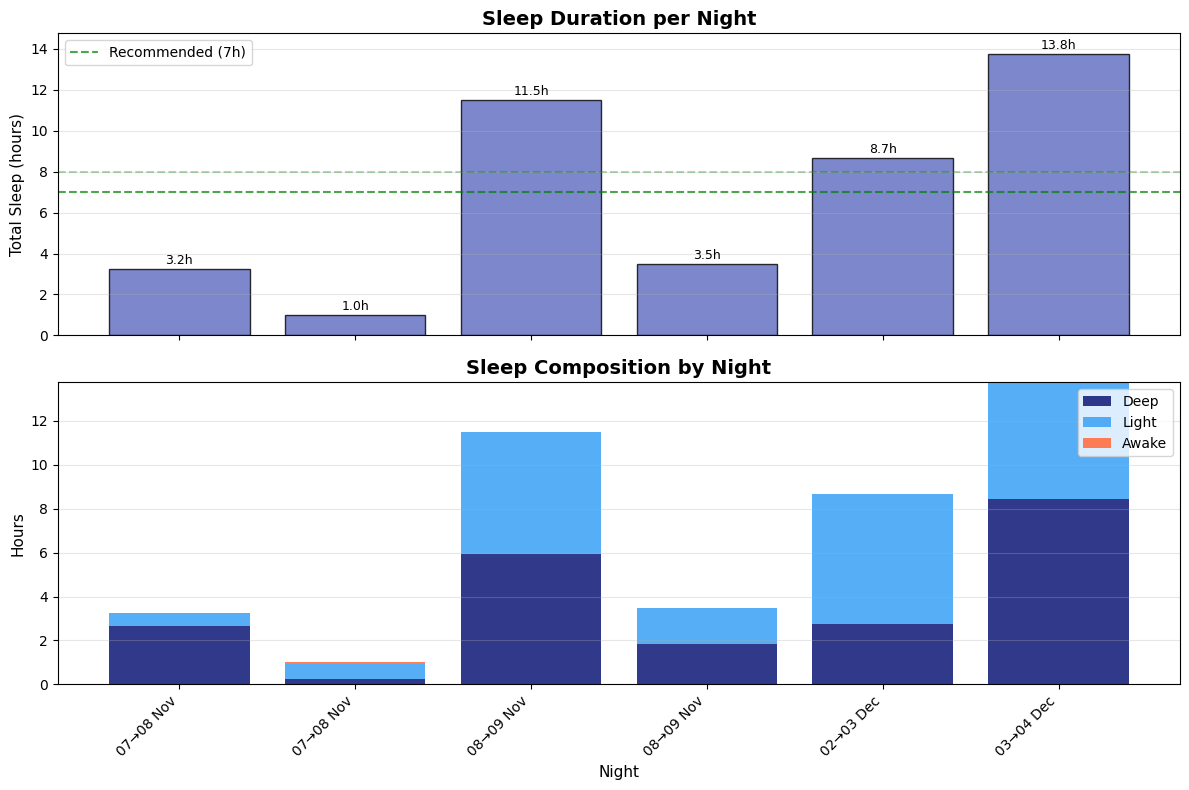


✅ Saved: daily_summary.png


In [76]:
if not nights_data:
    print("⚠️ No data to display")
else:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    x_pos = range(len(nights_data))
    labels = [n['label'] for n in nights_data]
    
    # Chart 1: Total duration
    ax1 = axes[0]
    total_hours = [n['total'] / 60 for n in nights_data]
    bars = ax1.bar(x_pos, total_hours, color='#5c6bc0', alpha=0.8, edgecolor='black')
    ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, label='Recommended (7h)')
    ax1.axhline(y=8, color='green', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Total Sleep (hours)', fontsize=11)
    ax1.set_title('Sleep Duration per Night', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(total_hours) + 1)
    
    for bar, hours in zip(bars, total_hours):
        if hours > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{hours:.1f}h', ha='center', va='bottom', fontsize=9)
    
    # Chart 2: Composition
    ax2 = axes[1]
    deep_h = [n['deep'] / 60 for n in nights_data]
    light_h = [n['light'] / 60 for n in nights_data]
    awake_h = [n['awake'] / 60 for n in nights_data]
    
    ax2.bar(x_pos, deep_h, label='Deep', color='#1a237e', alpha=0.9)
    ax2.bar(x_pos, light_h, bottom=deep_h, label='Light', color='#42a5f5', alpha=0.9)
    ax2.bar(x_pos, awake_h, bottom=[d + l for d, l in zip(deep_h, light_h)], 
            label='Awake', color='#ff7043', alpha=0.9)
    
    ax2.set_xlabel('Night', fontsize=11)
    ax2.set_ylabel('Hours', fontsize=11)
    ax2.set_title('Sleep Composition by Night', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('daily_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved: daily_summary.png")

## 📋 Last Night Details

Detailed information about the most recent sleep session.

In [77]:
if nights_data:
    last = nights_data[-1]
    
    # Convert to local time
    local_bedtime = to_local(last['bedtime'])
    local_wake = to_local(last['wake_time'])
    
    print("="*50)
    print(f"  LAST NIGHT: {last['label']}")
    print("="*50)
    print(f"")
    print(f"  Bedtime:     {local_bedtime.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
    print(f"  Wake:        {local_wake.strftime('%H:%M')} (UTC+{LOCAL_TZ_OFFSET})")
    print(f"")
    print(f"  Total duration:  {format_duration(last['total'])}")
    print(f"  - Deep Sleep:    {format_duration(last['deep'])} ({last['deep']/last['total']*100:.0f}%)")
    print(f"  - Light Sleep:   {format_duration(last['light'])} ({last['light']/last['total']*100:.0f}%)")
    print(f"  - Awake:         {format_duration(last['awake'])} ({last['awake']/last['total']*100:.0f}%)")
    print(f"")
    print(f"  Efficiency:      {last['efficiency']:.0f}%")
    print(f"  Records:         {last['records']}")
    print("="*50)
else:
    print("⚠️ No data available")

  LAST NIGHT: 03→04 Dec

  Bedtime:     20:25 (UTC+1)
  Wake:        11:20 (UTC+1)

  Total duration:  13h 45m
  - Deep Sleep:    8h 25m (61%)
  - Light Sleep:   5h 20m (39%)
  - Awake:         0m (0%)

  Efficiency:      100%
  Records:         16


## 🔬 Smart Sleep Analysis

Detect **real sleep periods** by analyzing activity patterns:
- High activity (>15) = likely awake
- Transition from high to low = falling asleep
- Sustained zeros = deep sleep
- Morning activity spikes = waking up

In [6]:
# Smart Sleep Analysis - Detect real sleep boundaries
AWAKE_THRESHOLD = 8        # Activity index > this = likely not in deep sleep
DEFINITELY_AWAKE = 15      # Activity > this = definitely awake
DEEP_SLEEP_THRESHOLD = 3   # Activity <= this for sustained period = deep sleep
MIN_DEEP_STREAK = 4        # Need 4+ low intervals (20 min) to confirm real sleep

def analyze_sleep_boundaries(session_records):
    """
    Analyze a session to find REAL sleep start/end times
    Returns: (real_bedtime, real_wake, analysis_notes)
    """
    if not session_records:
        return None, None, []
    
    notes = []
    all_intervals = []
    
    # Flatten all activity data with timestamps
    for rec in session_records:
        base_time = rec['datetime']
        for i, activity in enumerate(rec['activity_indices']):
            interval_time = base_time + timedelta(minutes=i * 5)
            all_intervals.append({
                'time': interval_time,
                'activity': activity,
                'local_time': to_local(interval_time)
            })
    
    if not all_intervals:
        return session_records[0]['datetime'], session_records[-1]['datetime'], notes
    
    # === FIND REAL SLEEP START ===
    # Look for first sustained period of low activity (< 3) after any initial high activity
    real_sleep_start = None
    consecutive_deep = 0
    had_initial_awake = False
    
    for i, interval in enumerate(all_intervals):
        activity = interval['activity']
        
        # Track if there was initial awake period
        if activity > AWAKE_THRESHOLD and real_sleep_start is None:
            had_initial_awake = True
            notes.append(f"👀 Active at {interval['local_time'].strftime('%H:%M')} (activity={activity})")
            consecutive_deep = 0
        elif activity <= DEEP_SLEEP_THRESHOLD:
            consecutive_deep += 1
            if consecutive_deep >= MIN_DEEP_STREAK and real_sleep_start is None:
                # Found real sleep start
                start_idx = i - consecutive_deep + 1
                real_sleep_start = all_intervals[start_idx]['time']
                notes.append(f"💤 Real sleep started ~{to_local(real_sleep_start).strftime('%H:%M')}")
        else:
            # Medium activity - reset deep streak but don't mark as awake
            if activity > AWAKE_THRESHOLD:
                consecutive_deep = 0
    
    # === FIND REAL WAKE TIME ===
    # Scan backwards from end to find last wake activity
    real_wake_time = None
    
    # Look for morning activity pattern
    for i in range(len(all_intervals) - 1, max(0, len(all_intervals) - 50), -1):
        interval = all_intervals[i]
        local_hour = interval['local_time'].hour
        
        # Morning hours check
        if 5 <= local_hour <= 12:
            if interval['activity'] >= DEFINITELY_AWAKE:
                # Found definite wake - but check if there's earlier wake
                # Look backwards for transition from sleep to awake
                for j in range(i, max(0, i - 20), -1):
                    if all_intervals[j]['activity'] <= DEEP_SLEEP_THRESHOLD:
                        # Found sleep before this - wake is between j and i
                        for k in range(j, i + 1):
                            if all_intervals[k]['activity'] > AWAKE_THRESHOLD:
                                real_wake_time = all_intervals[k]['time']
                                notes.append(f"⏰ First wake ~{to_local(real_wake_time).strftime('%H:%M')} (activity={all_intervals[k]['activity']})")
                                break
                        break
                if real_wake_time:
                    break
    
    # If no clear morning wake found, look for any late activity spike
    if real_wake_time is None:
        for i in range(len(all_intervals) - 1, -1, -1):
            if all_intervals[i]['activity'] >= DEFINITELY_AWAKE:
                # Check if preceded by sleep
                has_sleep_before = any(
                    all_intervals[j]['activity'] <= DEEP_SLEEP_THRESHOLD 
                    for j in range(max(0, i - 10), i)
                )
                if has_sleep_before:
                    real_wake_time = all_intervals[i]['time']
                    notes.append(f"⏰ Woke up ~{to_local(real_wake_time).strftime('%H:%M')} (activity={all_intervals[i]['activity']})")
                    break
    
    # Defaults
    if real_sleep_start is None:
        real_sleep_start = session_records[0]['datetime']
        notes.append("ℹ️ No clear sleep onset detected - using session start")
    if real_wake_time is None:
        real_wake_time = session_records[-1]['datetime'] + timedelta(minutes=session_records[-1]['duration_min'])
        notes.append("ℹ️ No clear wake detected - using session end")
    
    return real_sleep_start, real_wake_time, notes


def calculate_real_sleep_stats(session_records, real_start, real_end):
    """Calculate sleep stats only for the REAL sleep period"""
    deep, light, awake = 0, 0, 0
    
    for rec in session_records:
        rec_start = rec['datetime']
        
        for i, activity in enumerate(rec['activity_indices']):
            interval_start = rec_start + timedelta(minutes=i * 5)
            interval_end = interval_start + timedelta(minutes=5)
            
            if interval_end <= real_start or interval_start >= real_end:
                continue
            
            if activity == 0:
                deep += 5
            elif activity <= 20:
                light += 5
            else:
                awake += 5
    
    return deep, light, awake


# Analyze each night session
print("🔬 SMART SLEEP ANALYSIS")
print("="*110)
print(f"\nAnalyzing activity patterns to find REAL sleep times...\n")

for night in nights_data:
    if "NIGHT" not in night['type']:
        continue
    
    # Find the session records for this night
    session_recs = []
    for rec in valid_records:
        rec_time = rec['datetime']
        if night['bedtime'] <= rec_time <= night['wake_time']:
            session_recs.append(rec)
    
    real_start, real_end, analysis_notes = analyze_sleep_boundaries(session_recs)
    real_deep, real_light, real_awake = calculate_real_sleep_stats(session_recs, real_start, real_end)
    real_total = real_deep + real_light + real_awake
    
    local_real_start = to_local(real_start)
    local_real_end = to_local(real_end)
    local_tracker_start = to_local(night['bedtime'])
    local_tracker_end = to_local(night['wake_time'])
    
    diff = night['total'] - real_total
    
    print(f"📅 {night['label']}")
    print("-"*70)
    print(f"   📱 Tracker says:  {local_tracker_start.strftime('%H:%M')} → {local_tracker_end.strftime('%H:%M')} ({format_duration(night['total'])})")
    print(f"   🎯 Real sleep:    {local_real_start.strftime('%H:%M')} → {local_real_end.strftime('%H:%M')} ({format_duration(real_total)})")
    
    if diff > 0:
        print(f"   ⚠️  Overcounted:  {format_duration(diff)}")
    
    if analysis_notes:
        print(f"\n   🔍 Activity analysis:")
        for note in analysis_notes:
            print(f"      {note}")
    
    if real_total > 0:
        deep_pct = real_deep / real_total * 100
        print(f"\n   📊 Real composition:")
        print(f"      Deep:  {format_duration(real_deep)} ({deep_pct:.0f}%)")
        print(f"      Light: {format_duration(real_light)}")
        print(f"      Awake: {format_duration(real_awake)}")
    
    print()

print("="*110)
print("\n💡 TIP: Activity values meaning:")
print("   0-3   = Deep sleep (very little movement)")
print("   4-20  = Light sleep (some movement)")
print("   >20   = Awake (significant movement)")

🔬 SMART SLEEP ANALYSIS

Analyzing activity patterns to find REAL sleep times...

📅 07→08 Nov
----------------------------------------------------------------------
   📱 Tracker says:  21:25 → 00:40 (3h 15m)
   🎯 Real sleep:    21:25 → 00:40 (3h 15m)

   🔍 Activity analysis:
      💤 Real sleep started ~21:25
      ℹ️ No clear wake detected - using session end

   📊 Real composition:
      Deep:  2h 50m (87%)
      Light: 25m
      Awake: 0m

📅 08→09 Nov
----------------------------------------------------------------------
   📱 Tracker says:  20:19 → 05:29 (9h 30m)
   🎯 Real sleep:    20:34 → 05:29 (9h 15m)
   ⚠️  Overcounted:  15m

   🔍 Activity analysis:
      👀 Active at 20:19 (activity=19)
      💤 Real sleep started ~20:34
      ℹ️ No clear wake detected - using session end

   📊 Real composition:
      Deep:  7h 25m (80%)
      Light: 1h 50m
      Awake: 0m

📅 02→03 Dec
----------------------------------------------------------------------
   📱 Tracker says:  00:25 → 07:24 (8h 40m)

## 📈 Activity Timeline per Night

Visualizzazione dettagliata dell'activity index nel tempo per ogni notte, per vedere chiaramente i pattern di sonno e veglia.

C:\Users\Admin\AppData\Local\Temp\ipykernel_28660\3114545121.py:106: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28660\3114545121.py:106: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28660\3114545121.py:106: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_28660\3114545121.py:108: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.savefig('activity_timeline.png', dpi=150, bbox_inches='tight', facecolor='white')
C:\Users\Admin\AppData\Local\Temp\ipykernel_28660\3114545121.py:108: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig('activity_timeline.png', dpi=150, bbox_inches='tight', facecolor='white')
C:\Users\Admin\AppData\Loc

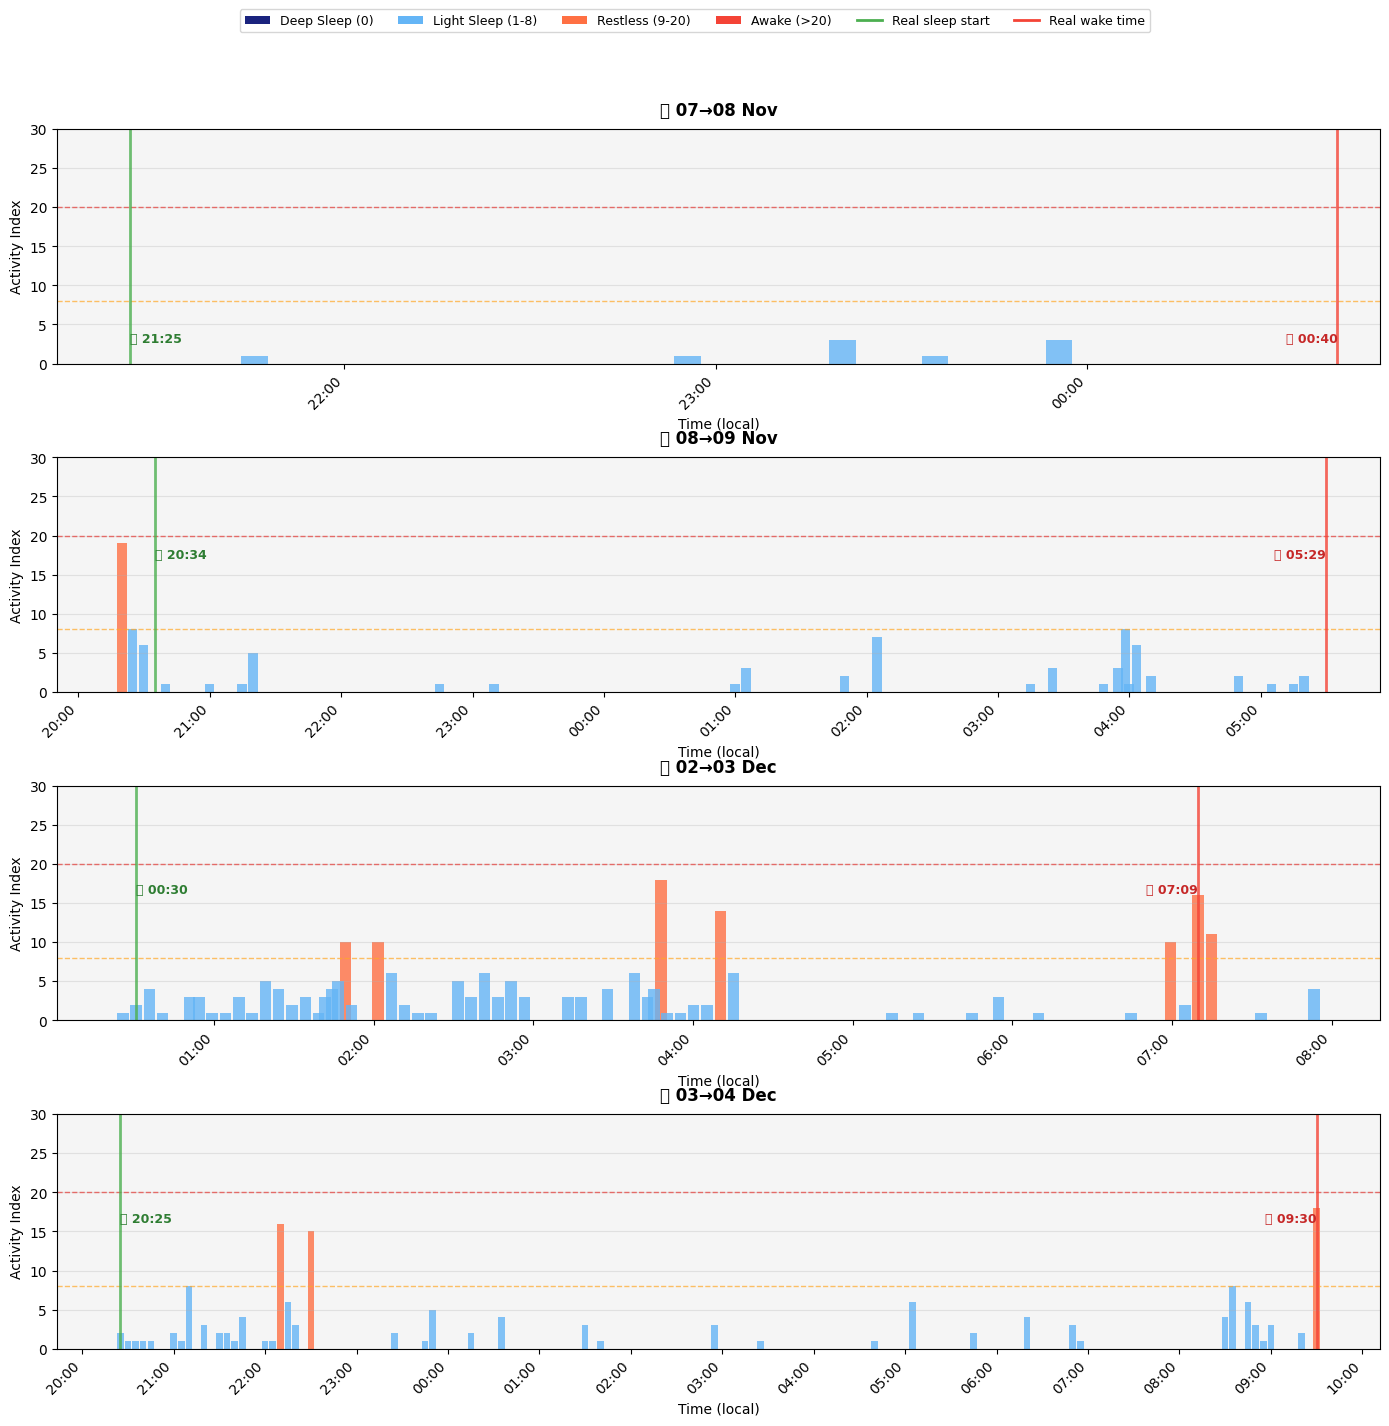


✅ Saved: activity_timeline.png


In [7]:
# Activity Timeline Visualization
import matplotlib.dates as mdates

# Filter only NIGHT sessions
night_sessions = [n for n in nights_data if "NIGHT" in n['type']]

# Create figure with subplots for each night
fig, axes = plt.subplots(len(night_sessions), 1, figsize=(14, 3.5 * len(night_sessions)))
if len(night_sessions) == 1:
    axes = [axes]

colors_activity = {
    'deep': '#1a237e',      # Dark blue - deep sleep
    'light': '#64b5f6',     # Light blue - light sleep  
    'awake': '#ff7043',     # Orange - awake
    'active': '#f44336',    # Red - very active
}

for idx, night in enumerate(night_sessions):
    ax = axes[idx]
    
    # Get session records
    session_recs = []
    for rec in valid_records:
        rec_time = rec['datetime']
        if night['bedtime'] <= rec_time <= night['wake_time']:
            session_recs.append(rec)
    
    # Build timeline data
    times = []
    activities = []
    colors = []
    
    for rec in session_recs:
        base_time = rec['datetime']
        for i, activity in enumerate(rec['activity_indices']):
            interval_time = to_local(base_time + timedelta(minutes=i * 5))
            times.append(interval_time)
            activities.append(activity)
            
            # Color based on activity level
            if activity == 0:
                colors.append(colors_activity['deep'])
            elif activity <= 8:
                colors.append(colors_activity['light'])
            elif activity <= 20:
                colors.append(colors_activity['awake'])
            else:
                colors.append(colors_activity['active'])
    
    # Plot bars
    if times:
        ax.bar(times, activities, width=0.003, color=colors, edgecolor='none', alpha=0.8)
        
        # Add threshold lines
        ax.axhline(y=8, color='#ffa726', linestyle='--', linewidth=1, alpha=0.7, label='Awake threshold (8)')
        ax.axhline(y=20, color='#e53935', linestyle='--', linewidth=1, alpha=0.7, label='Very active (20)')
        
        # Analyze boundaries for this night
        real_start, real_end, _ = analyze_sleep_boundaries(session_recs)
        
        # Mark real sleep boundaries
        real_start_local = to_local(real_start)
        real_end_local = to_local(real_end)
        
        ax.axvline(x=real_start_local, color='#4caf50', linestyle='-', linewidth=2, alpha=0.8)
        ax.axvline(x=real_end_local, color='#f44336', linestyle='-', linewidth=2, alpha=0.8)
        
        # Labels for boundaries
        y_max = max(activities) if activities else 20
        ax.annotate(f'💤 {real_start_local.strftime("%H:%M")}', 
                   xy=(real_start_local, y_max * 0.9),
                   fontsize=9, color='#2e7d32', fontweight='bold',
                   ha='left')
        ax.annotate(f'⏰ {real_end_local.strftime("%H:%M")}', 
                   xy=(real_end_local, y_max * 0.9),
                   fontsize=9, color='#c62828', fontweight='bold',
                   ha='right')
    
    # Formatting
    ax.set_title(f"📅 {night['label']}", fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Activity Index', fontsize=10)
    ax.set_xlabel('Time (local)', fontsize=10)
    ax.set_ylim(0, max(30, max(activities) + 5) if activities else 30)
    
    # Format x-axis with hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_facecolor('#f5f5f5')

# Legend
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor=colors_activity['deep'], label='Deep Sleep (0)'),
    plt.Rectangle((0,0),1,1, facecolor=colors_activity['light'], label='Light Sleep (1-8)'),
    plt.Rectangle((0,0),1,1, facecolor=colors_activity['awake'], label='Restless (9-20)'),
    plt.Rectangle((0,0),1,1, facecolor=colors_activity['active'], label='Awake (>20)'),
    plt.Line2D([0], [0], color='#4caf50', linewidth=2, label='Real sleep start'),
    plt.Line2D([0], [0], color='#f44336', linewidth=2, label='Real wake time'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=6, fontsize=9, 
           bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4)
plt.savefig('activity_timeline.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("\n✅ Saved: activity_timeline.png")